In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.spatial.distance import euclidean

In [3]:
data = pd.read_csv('./Financial Well-Being Survey Data/NFWBS_PUF_2016_data.csv')

print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} features.')

The dataset contains 6394 rows and 217 features.


# Data exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6394 entries, 0 to 6393
Columns: 217 entries, PUF_ID to finalwt
dtypes: float64(2), int64(215)
memory usage: 10.6 MB


In [4]:
data.head()

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
3,7267,1,3,6,6,6,49,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
4,7375,1,3,4,4,4,49,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


In [6]:
max(data.isna().sum()) # no explicit missing values

0

In [7]:
data.columns.values

array(['sample', 'fpl', 'SWB_1', 'SWB_2', 'SWB_3', 'FWBscore', 'FWB1_1',
       'FWB1_2', 'FWB1_3', 'FWB1_4', 'FWB1_5', 'FWB1_6', 'FWB2_1',
       'FWB2_2', 'FWB2_3', 'FWB2_4', 'FSscore', 'FS1_1', 'FS1_2', 'FS1_3',
       'FS1_4', 'FS1_5', 'FS1_6', 'FS1_7', 'FS2_1', 'FS2_2', 'FS2_3',
       'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS', 'PROPPLAN_1',
       'PROPPLAN_2', 'PROPPLAN_3', 'PROPPLAN_4', 'MANAGE1_1', 'MANAGE1_2',
       'MANAGE1_3', 'MANAGE1_4', 'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1',
       'AUTOMATED_2', 'ASK1_1', 'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1',
       'CHANGEABLE', 'GOALCONF', 'LMscore', 'FINKNOWL1', 'FINKNOWL2',
       'FINKNOWL3', 'FK1correct', 'FK2correct', 'FK3correct', 'KHscore',
       'KHKNOWL1', 'KHKNOWL2', 'KHKNOWL3', 'KHKNOWL4', 'KHKNOWL5',
       'KHKNOWL6', 'KHKNOWL7', 'KHKNOWL8', 'KHKNOWL9', 'KH1correct',
       'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct',
       'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct', 'ENDSMEET',
       'H

## Missing data

- -5: County not known (Applies to PCTLT200FPL. County was not known for these respondents and details on the county-level degree of poverty could not be merged in for these cases.) ACTION: 395 rows

- -4: Response not written to the database due to error (SWB and FWB variables) ACTION: only one record -> drop (?)

- -3: Invalid response/ Incoherent data (SOCSEC2, SOCSEC3, KIDS) ACTION: 234 rows for SOCSEC + 1 row for KIDS_2 drop(?)

- -2: Question not asked because respondant not in item base (VALUERANGES, MORTGAGE, PAIDHELP, SOCSEC1, SOCSEC2, SOCSEC3, LIFEEXPECT and RETIRE). The respondent was correctly skipped over this item based on responses to previous questions or panel data on respondant age ACTION: ? pesquisar

- -1: Not answered/ Left blank (Applies to most items) ACTION: 2302 rows with missing data (impute; see how to impute each case specifically)

- 8: I can’t recall (HSLOC) ACTION: 21 rows -> impute with mode (?)

- 98: Don't know (HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES) ACTION: 514 rows -> impute

- 99: Prefer not to say (HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES,  EMPLOY: Analysis variable of EMPLOY1-9 -> if EMPLOY did not select any, it is a missing value) ACTION: 1466 rows -> impute

__-5: County not known__

PCTLT200FPL: percentage of people who live in the same county as the survey respondent who have an income that is below 200% of the federal poverty level

-5 when unkown county of the responded

395 rows

How to solve this?
- impute: The narrowest information we have about respondant's residence is the census division. If we imputed with the census division percentage of people with income below 200% of FPL, all imputed values would be 0. Instead, it would be better to use a KNNimputer: variables that possibly relate people that live in the same county: Census division (PPREG9), Household income (PPINCIMP), Education (PPEDUC), Age (agecat), Financial Hardship (MATHARDSHIP_1 - MATHARDSHIP_6)

In [8]:
data[data['PCTLT200FPL'] == -5]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
11615,3,3,5,4,5,59,3,3,3,4,...,1,4,8,0,0,0,0,1,-5,0.749584
14199,3,2,3,4,6,43,1,4,5,2,...,1,3,7,0,0,0,0,3,-5,1.504086
11487,3,3,7,7,7,57,2,4,2,4,...,1,3,6,0,0,0,0,2,-5,0.844349
7194,3,3,6,6,7,41,4,4,4,4,...,1,3,5,0,0,0,0,2,-5,0.649568
13757,3,1,5,7,7,57,2,3,2,3,...,1,4,9,0,0,0,0,4,-5,0.785893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13144,3,2,6,7,7,58,3,4,3,4,...,1,3,5,0,0,0,0,1,-5,1.577823
11620,3,2,7,6,7,44,2,3,2,3,...,1,4,9,0,1,1,0,4,-5,2.563018
11220,3,3,6,7,7,61,3,3,1,3,...,1,2,3,0,0,0,1,2,-5,0.522504


In [9]:
data['PCTLT200FPL'].value_counts()

 0    4548
 1    1451
-5     395
Name: PCTLT200FPL, dtype: int64

<AxesSubplot:xlabel='PPREG9'>

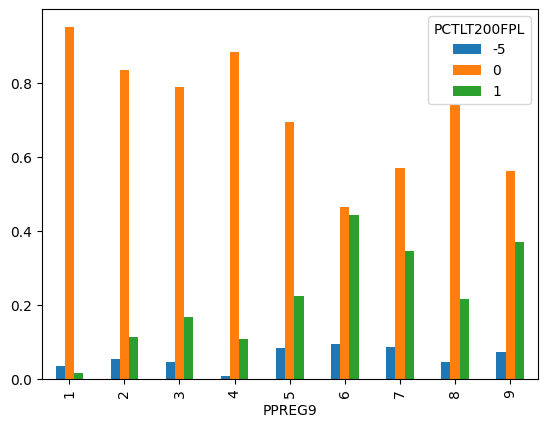

In [10]:
# plot the number of people with PCTLT200FPL = 0 and PCTLT200FPL = 1 for each PPREG9
data.groupby('PPREG9')['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar()

# the census region clearly discriminates the two classes

<AxesSubplot:xlabel='PPINCIMP'>

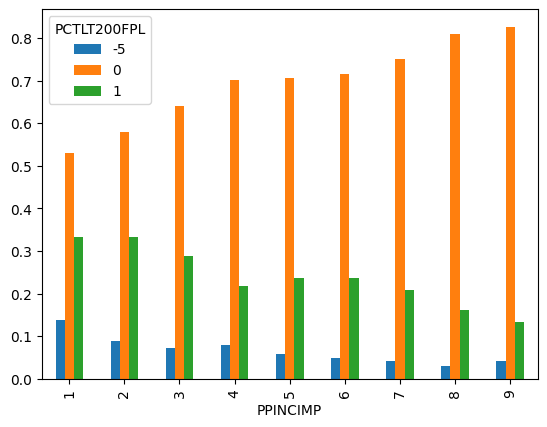

In [11]:
data.groupby('PPINCIMP')['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar()

# Discriminates well -> percentage of 0 and 1 is diffferent among all income groups

<AxesSubplot:xlabel='PPEDUC'>

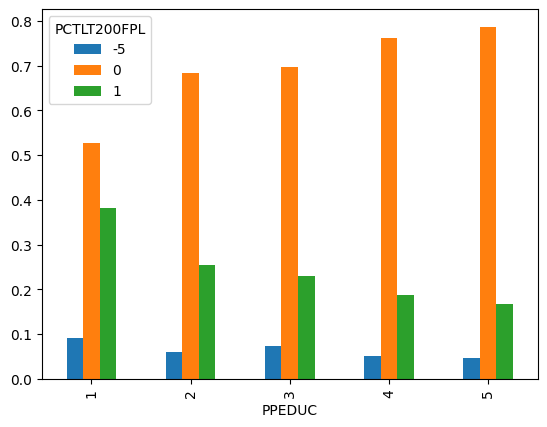

In [12]:
data.groupby('PPEDUC')['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar()

# only discriminates between educ = 1 and educ != 1

<AxesSubplot:xlabel='agecat'>

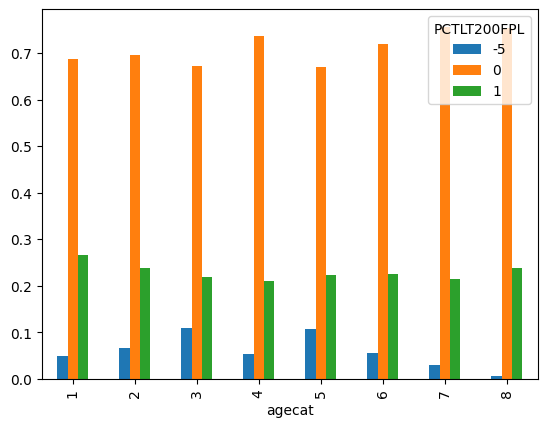

In [13]:
data.groupby('agecat')['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar()

# not good to discriminate

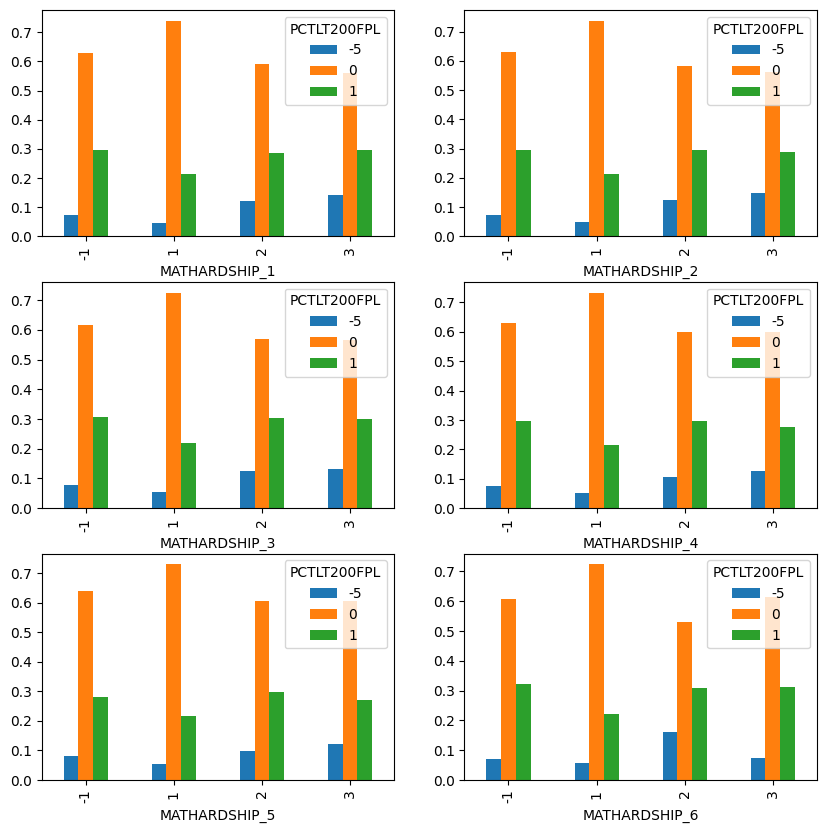

In [14]:
# 6 subplots with MATHARDSHIP_1, MATHARDSHIP_2, MATHARDSHIP_3, MATHARDSHIP_4, MATHARDSHIP_5, MATHARDSHIP_6 vs PCTLT200FPL
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(1, 7):
    data.groupby(f'MATHARDSHIP_{i}')['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Not really discriminating and all very similar and have missing values.

Conclusion: calculate KNN using PPREG9, PPINCIMP and PPEDUC

PPREG9 -> categorical
PPINCIMP -> ordinal
PPEDUC -> ordinal

distance to find nearest neighbors: euclidean for PPINC, PPEDUC  + one hot for PPREG9

__-4: Response not written to the database due to error__

SWB and FWB

How to solve this?
- drop: only one row affected

In [15]:
data[(data == -4).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
12173,1,3,-4,-4,-4,-4,-4,-4,-4,-4,...,1,3,5,0,0,0,0,1,0,1.253964


__-3: Invalid response/ Incoherent data__

SOCSEC2, SOCSEC3, KIDS_2

SOCSEC2: 'At what age did you begin receiving benefits'. Invalid when answered < 62 years

SOCSEC3: 'Age likely to start receiving Social Security retirement benefits'. Invalid when respondant age is two or more year greater than given response

KIDS_2 asks for the number of children of age between 7 to 12 that the respondent supports financially

235 rows with invalid data
- 166 from SOCSEC2
- 68 from SOCSEC3
- 1 from KIDS_2

What to do?
- impute SOCSEC2: Using KNN -> variables that could tell us at what age respondant started receiving SS retirement benefits: SOCSEC == 1; EMPLOOY == 8; agecat, PPGENDER, PPEDUC, PPINCIMP, PPMARIT, AUTOMATED_1
- impute SOCSEC3 the same way as SOCSEC2
- drop KIDS_2

In [16]:
data[data['SOCSEC2'] == -3].shape[0]

166

In [17]:
data[data['SOCSEC3'] == -3].shape[0]

68

In [18]:
data[data['KIDS_2'] == -3].shape[0]

1

In [19]:
data[(data[['SOCSEC2', 'SOCSEC3', 'KIDS_2']] == -3).any(axis = 1)][['SOCSEC2', 'SOCSEC3', 'KIDS_2']]

,SOCSEC2,SOCSEC3,KIDS_2
PUF_ID,,,
12675,-3,-2,0
9182,-3,-2,0
10550,-3,-2,0
11083,-3,-2,0
9185,-3,-2,0
...,...,...,...
12971,-3,-2,0
11077,-3,-2,0
13171,-2,-3,0


In [20]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,3,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
10127,1,3,5,7,7,62,4,3,2,5,...,0,4,8,0,0,0,0,2,0,0.745163
8122,1,3,7,6,7,69,4,4,3,4,...,1,1,1,0,0,0,0,2,0,0.495053
10351,2,3,5,5,5,61,3,3,2,3,...,1,4,9,0,0,0,0,1,0,0.450494
11353,1,3,7,6,6,80,5,4,1,4,...,1,3,6,0,0,0,0,1,1,0.389242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12636,3,3,5,5,6,49,2,3,3,3,...,1,4,9,0,0,0,0,2,-5,0.494555
13312,3,3,6,6,6,58,3,1,3,3,...,1,3,5,0,0,0,0,2,-5,0.449542
10754,2,3,4,4,4,57,4,4,2,4,...,1,3,5,0,0,0,0,2,1,0.299912


<AxesSubplot:xlabel='agecat'>

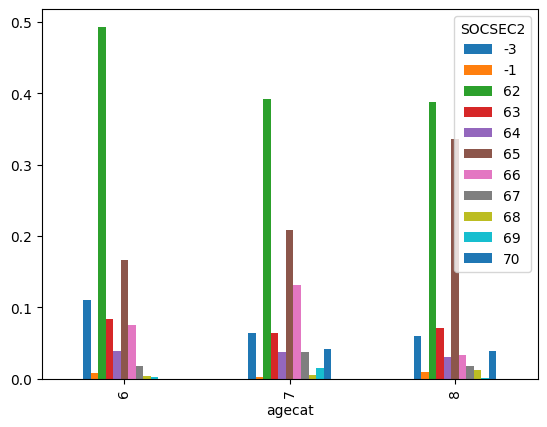

In [21]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)].groupby('agecat')['SOCSEC2'].value_counts(normalize = True).unstack().plot.bar()

# Discriminates well especially for agecat {6, 7} and 8

<AxesSubplot:xlabel='PPGENDER'>

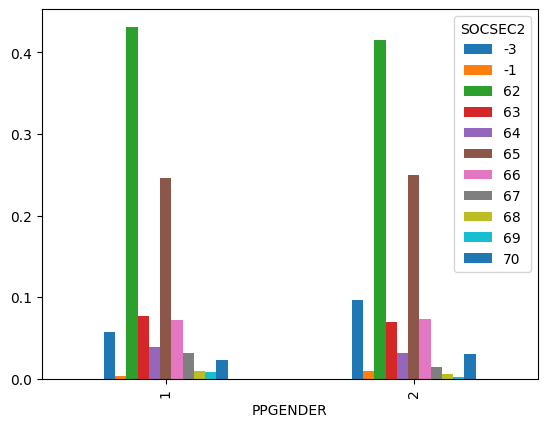

In [22]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)].groupby('PPGENDER')['SOCSEC2'].value_counts(normalize = True).unstack().plot.bar()

# Does not discriminate well

<AxesSubplot:xlabel='PPEDUC'>

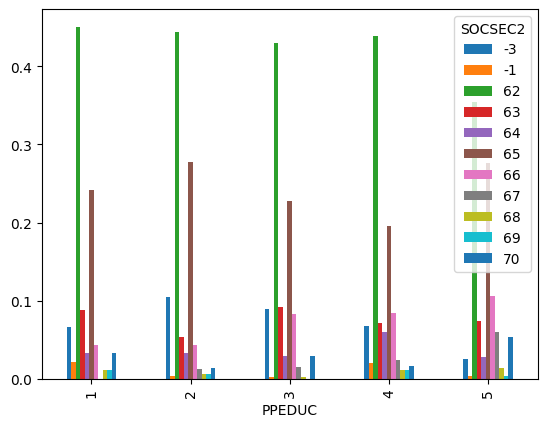

In [23]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)].groupby('PPEDUC')['SOCSEC2'].value_counts(normalize = True).unstack().plot.bar()

# Discriminates well

<AxesSubplot:xlabel='PPINCIMP'>

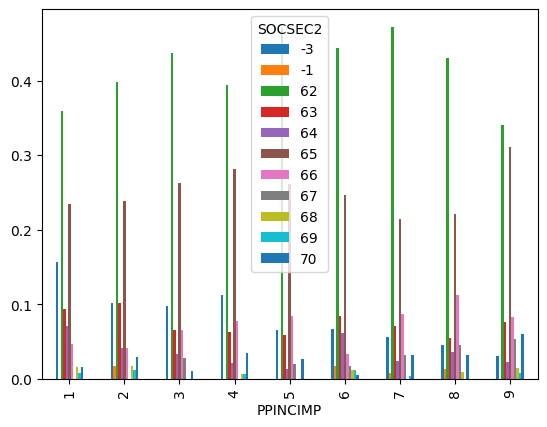

In [24]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)].groupby('PPINCIMP')['SOCSEC2'].value_counts(normalize = True).unstack().plot.bar()

# Discriminates well

<AxesSubplot:xlabel='PPMARIT'>

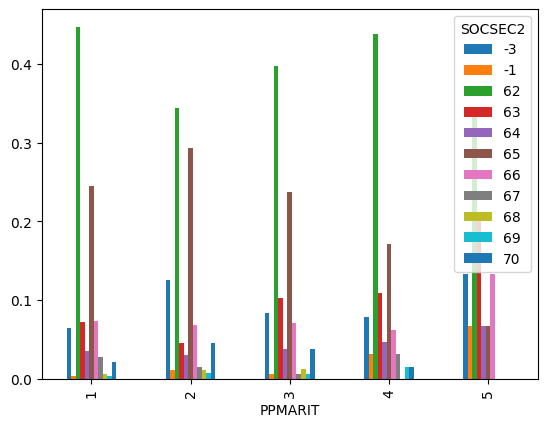

In [25]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)].groupby('PPMARIT')['SOCSEC2'].value_counts(normalize = True).unstack().plot.bar()

# Discriminates well inly between {1, 2, 3, 4} and 5

<AxesSubplot:xlabel='AUTOMATED_1'>

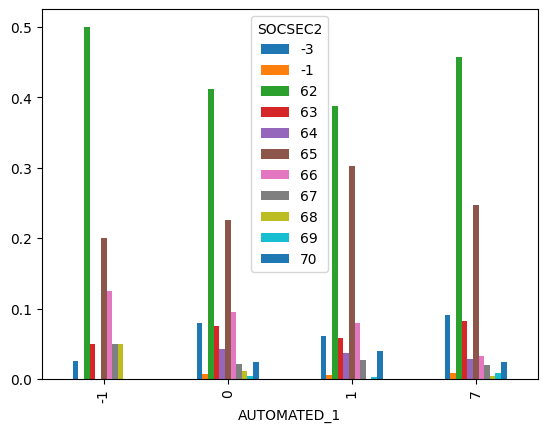

In [26]:
data[(data['SOCSEC1'] == 1) & (data['EMPLOY'] == 8)].groupby('AUTOMATED_1')['SOCSEC2'].value_counts(normalize = True).unstack().plot.bar()

# Discriminates well

Conclusion: let's use agecat, PPEDUC, PPINCIMP, PPMARIT and AUTOMATED_1

agecat: ordinal
PPEDUC: ordinal
PPINCIMP: ordinal
PPMARIT: categorical
AUTOMATED_1: categorical

distance: euclidean for agecat, PPEDUC and PPINCIMP + hamming for PPMARIT and AUTOMATED_1

__-2: Question not asked because respondant not in item base__

What to do?
- search!!!

In [27]:
data[(data == -2).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,3,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
7740,1,3,6,6,6,51,2,2,3,3,...,1,2,3,0,0,0,0,2,0,1.327561
13699,1,3,4,3,4,49,3,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,3,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,3,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11220,3,3,6,7,7,61,3,3,1,3,...,1,2,3,0,0,0,1,2,-5,0.522504
13118,3,2,7,7,7,59,3,4,2,4,...,1,3,6,0,0,0,0,3,-5,1.015219
8709,1,3,5,6,6,59,3,4,3,3,...,1,1,2,0,0,0,0,2,0,1.136270


__-1: Not answered/ Left blank__

2301 rows

What to do?
- SWB: median
- FWBscore: drop
- FSscore: drop
- SUBKNOWL1: median
- ACT:
- FINGOALS:
- PROPLAN:
- MANAGE:
- SAVEHABIT:
- FRUGALITY:
- AUTOMATED:
- ASK:
- SUBNUMERACY:
- CHANGEABLE:
- GOALCONF:
- ENDSMEET:
- HOUSING:
- LIVINGARRANGEMENT:
- HOUSERANGES:
- VALUERANGES:
- MORTAGE:
- SAVINGSRANGES:
- CONSPROTECT:
- EARNERS:
- VOLATILITY:
- SNAP:
- MATHARDSHIP:
- COLLECT:
- REJECTED:
- ABSORBSHOCK:
- BENEFITS:
- FRAUD2:
- COVERCOSTS:
- BORROW:
- MANAGE2:
- PAIDHELP:
- HSLOC:
- PAREDUC:
- FINSOC:
- OBJNUMERACY1:
- MATERIALISM:
- CONNECT:
- HEALTH:
- SCFHORIZON:
- DISCOUNT:
- MEMLOSS:
- DISTRESS:
- SELFCONTROL:
- OUTLOOK:
- PEM:
- HOUSESAT:
- SOCSEC:
- LIFEEXPECT:
- HHEDUC:
- KIDS:
- RETIRE:
- MILITARY:
- Military_Status:

In [28]:
data[(data == -1).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,3,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
13699,1,3,4,3,4,49,3,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,3,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,3,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
8303,1,3,7,7,7,43,4,5,2,5,...,1,3,7,0,0,0,1,3,0,2.497838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11830,3,3,7,7,7,60,3,3,2,4,...,1,3,7,0,0,0,0,2,-5,1.162733
9431,1,3,5,7,7,45,3,3,4,4,...,1,3,5,0,0,0,0,2,0,0.432273
13144,3,2,6,7,7,58,3,4,3,4,...,1,3,5,0,0,0,0,1,-5,1.577823


__SBW: Subjective well-being and optimism questions__

'I am satisfied with my life'
<br>
'I am optimistic about my future'
<br>
'If I work hard today, I will be more succeful in the future'

It is hard to fill subjective data. Given the small amount of records with missing data and giving the large size of the dataset, a good approach is to use the median.

In [ ]:
data[list(filter(lambda x: 'SWB' in x, data.columns.values))].isna().sum()

SWB_1    30
SWB_2    56
SWB_3    64
dtype: int64

__FWBscore__

Drop or impute with median (?)

I guess dropping would be better because, even if there are only 4 observations with missing values, imputing with the median would induce error. Dropping 4 observations is not ptoblematic given the large size of the dataset. Moreover, these observations also have missing values in many other variables.

In [ ]:
data[data['FWBscore'].isna()]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7938,1.0,3.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,2.251537
7305,1.0,3.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.447239
7982,3.0,1.0,6.0,6.0,6.0,NaN,NaN,4.0,3.0,3.0,...,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.681337
7197,3.0,1.0,6.0,6.0,6.0,NaN,NaN,4.0,NaN,NaN,...,1.0,4.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,0.785893


__FSscore: Financial skill scale score__

Scale of 0 to 100

Same logic as before

In [ ]:
data[data['FSscore'].isna()]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7123,1.0,2.0,6.0,3.0,3.0,39.0,NaN,4.0,5.0,4.0,...,1.0,4.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.685003
13559,1.0,3.0,6.0,6.0,6.0,68.0,NaN,NaN,NaN,NaN,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.490585
8213,1.0,2.0,4.0,5.0,5.0,51.0,NaN,3.0,2.0,2.0,...,1.0,4.0,8.0,0.0,0.0,0.0,1.0,3.0,0.0,1.142545
7133,1.0,3.0,3.0,3.0,3.0,52.0,NaN,4.0,4.0,4.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.011039


__SUBKNOWL1: How would you assess your overall financial knowledge?__

Similarly to SWB questions, it is hard to fill subjective data. Given the small amount of records with missing data and giving the large size of the dataset, a good approach is to use the median.

In [ ]:
data[data['SUBKNOWL1'].isna()]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1.0,3.0,6.0,6.0,6.0,49.0,42.0,NaN,NaN,NaN,...,1.0,3.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.410871
12676,2.0,2.0,5.0,4.0,5.0,34.0,60.0,NaN,5.0,3.0,...,1.0,4.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.801112
8309,2.0,3.0,3.0,4.0,2.0,49.0,37.0,NaN,4.0,3.0,...,1.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.597089
9698,1.0,3.0,1.0,1.0,1.0,47.0,44.0,NaN,NaN,NaN,...,1.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.616893
8732,1.0,3.0,6.0,6.0,6.0,82.0,40.0,NaN,4.0,4.0,...,0.0,3.0,5.0,0.0,0.0,0.0,0.0,2.0,1.0,1.638231
9706,1.0,3.0,6.0,6.0,6.0,74.0,56.0,NaN,4.0,4.0,...,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.425748
11735,1.0,2.0,7.0,6.0,6.0,45.0,39.0,NaN,3.0,3.0,...,1.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,1.289141
12425,2.0,3.0,5.0,5.0,5.0,72.0,44.0,NaN,5.0,5.0,...,1.0,3.0,5.0,0.0,0.0,0.0,0.0,2.0,1.0,0.639250
13307,1.0,3.0,6.0,6.0,7.0,46.0,46.0,NaN,3.0,3.0,...,1.0,4.0,8.0,0.0,0.0,0.0,0.0,3.0,1.0,1.252628


__ACT__

'I follow-through on my financial commitments to others'
<br>
'I follow-through on financial goals I set to myself'

This questions are about financial responsibility and accountability, therefore we can use KNN to impute the missing values.

The other questions of this kind are FINGOALS, PROPPLAN, MANAGE and ASK:

'Do you have a current or recent financial goal?'
<br>
'I consult my budget to see how much money I have left'
<br>
'I actively consider the steps I need to take to stick to my budget'
<br>
'I set financial goals for what I want to achieve with my money'
<br>
'I prepare a clear plan of action w/ detailed steps to achieve my financial goals'
<br>
'Paid all your bills on time'
<br>
'Stayed within your budget or spending plan'
<br>
'I do my own research before making decisions involving money'
<br>
'I ask other people their opinions before making decisions involving money'

People with similar answers in this questions should have similar answer to ACT questions

In [ ]:
data[list(filter(lambda x: 'ACT' in x, data.columns.values))].isna().sum()

ACT1_1    20
ACT1_2    14
dtype: int64

<AxesSubplot:xlabel='FINGOALS'>

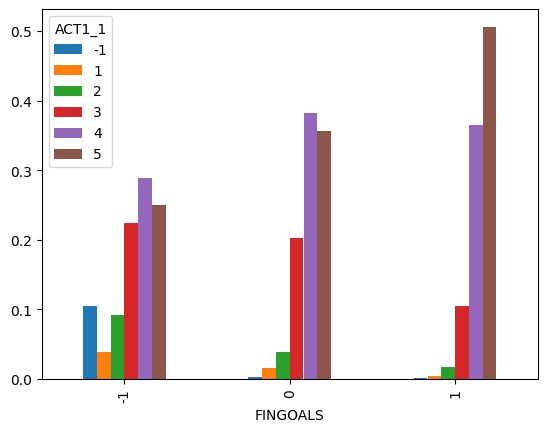

In [6]:
# plot of FINGOALS vs ACT_1
data.groupby('FINGOALS')['ACT1_1'].value_counts(normalize = True).unstack().plot.bar()

Discriminates well

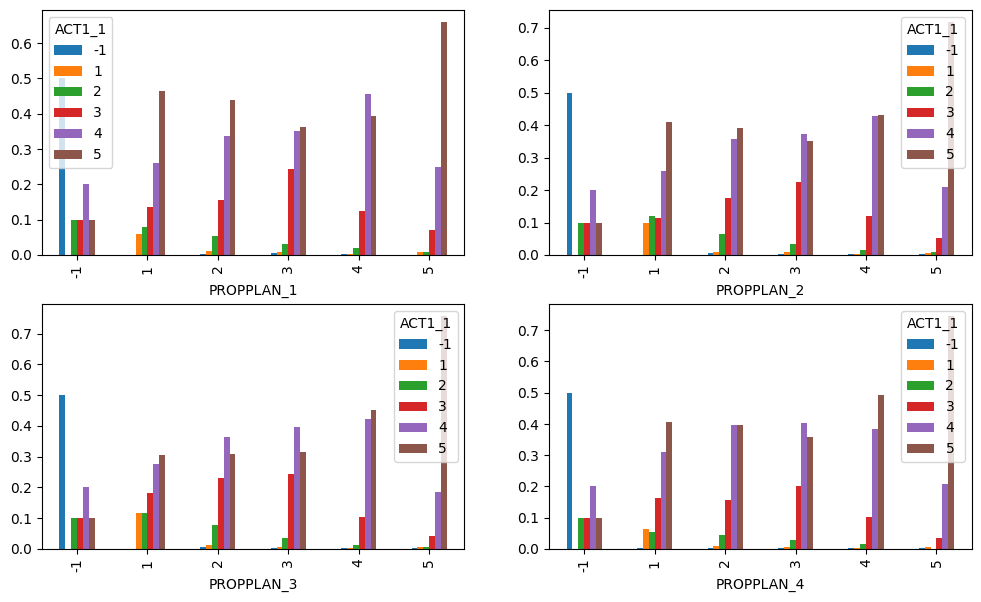

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i in range(1, 5):
    data.groupby(f'PROPPLAN_{i}')['ACT1_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Similar distribution of ACT1_1 answers among different PROPPLAN answers. In all plots, ACT1_1 answers are well discriminated among PROPPLAN possible answers. Let's use one of them: PROPPLAN_1

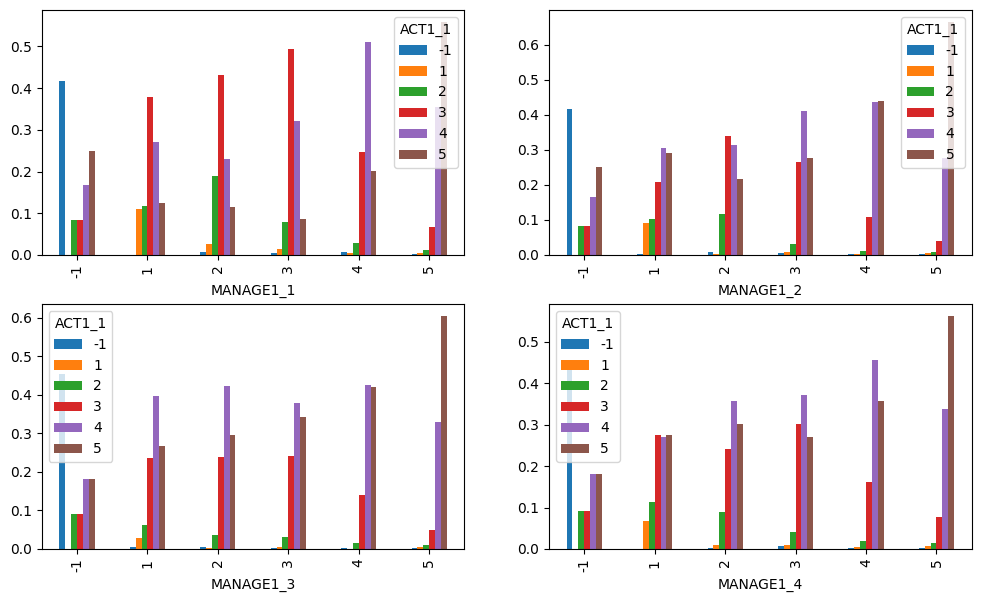

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i in range(1, 5):
    data.groupby(f'MANAGE1_{i}')['ACT1_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Similar distributions among MANAGE answers. Let's use only MANAGE1_1

<AxesSubplot:xlabel='ASK1_2'>

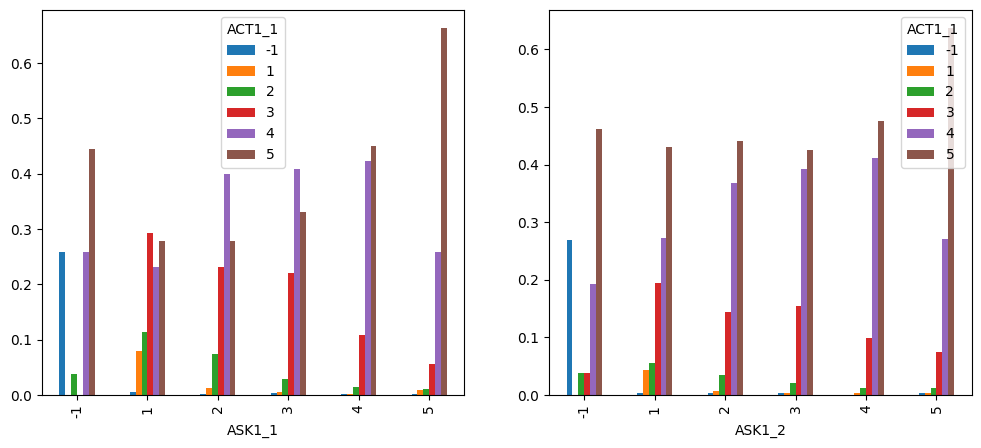

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

data.groupby('ASK1_1')['ACT1_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[0])
data.groupby('ASK1_2')['ACT1_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[1])

Again, answers to ACT1_1 differ a lot depending on the answer to ASK1_1 and ASK1_2. Let's use one of them: ASK1_1

Now, let's see what happpens with ACT1_2

<AxesSubplot:xlabel='FINGOALS'>

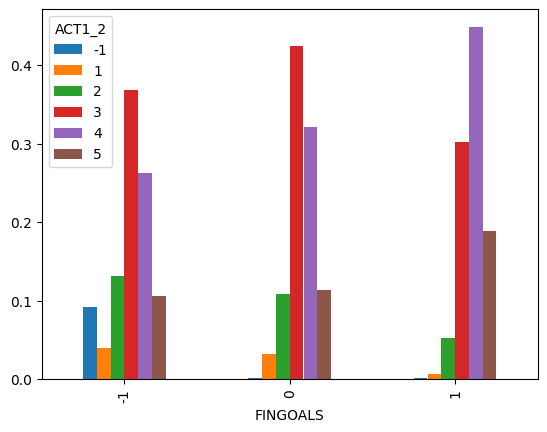

In [22]:
# plot of FINGOALS vs ACT_1
data.groupby('FINGOALS')['ACT1_2'].value_counts(normalize = True).unstack().plot.bar()

Discriminates well

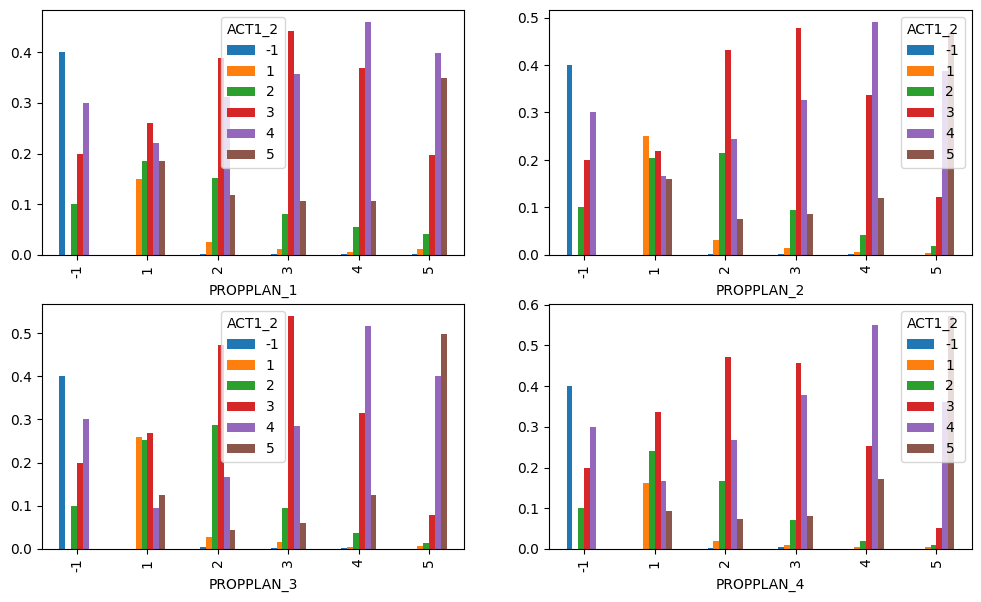

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i in range(1, 5):
    data.groupby(f'PROPPLAN_{i}')['ACT1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Similar distribution of ACT1_1 answers among {PROPPLAN_1, PROPPLAN_4} and {PROPPLAN_2, PROPPLAN_3} answers. In all plots, ACT1_2 answers are well discriminated among PROPPLAN possible answers. Let's use only one of them

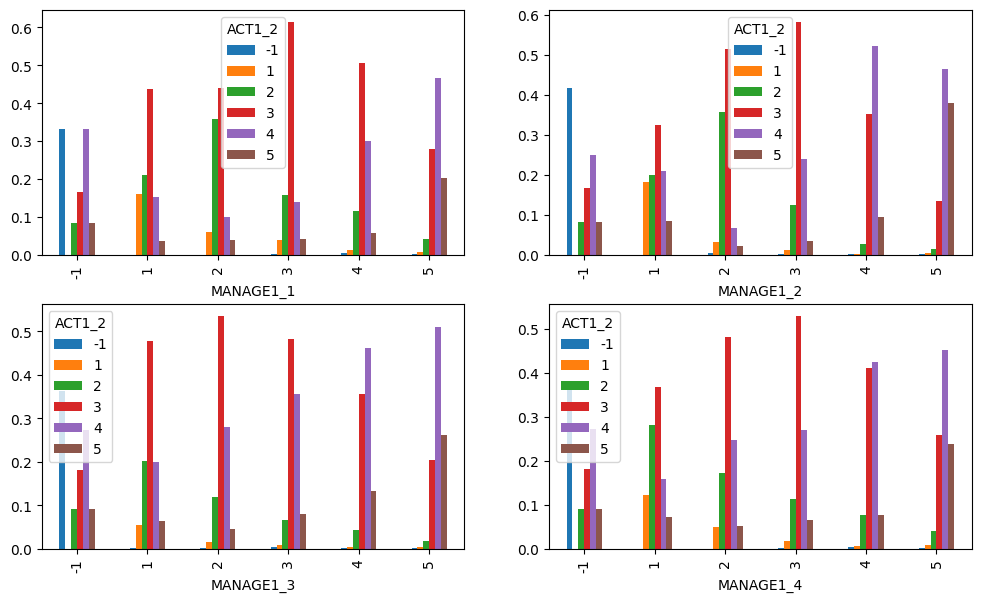

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i in range(1, 5):
    data.groupby(f'MANAGE1_{i}')['ACT1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

All discrimante differently but well. Let's just use one for simplicity, for example MANAGE1_2 since it discriminates the best.

<AxesSubplot:xlabel='ASK1_2'>

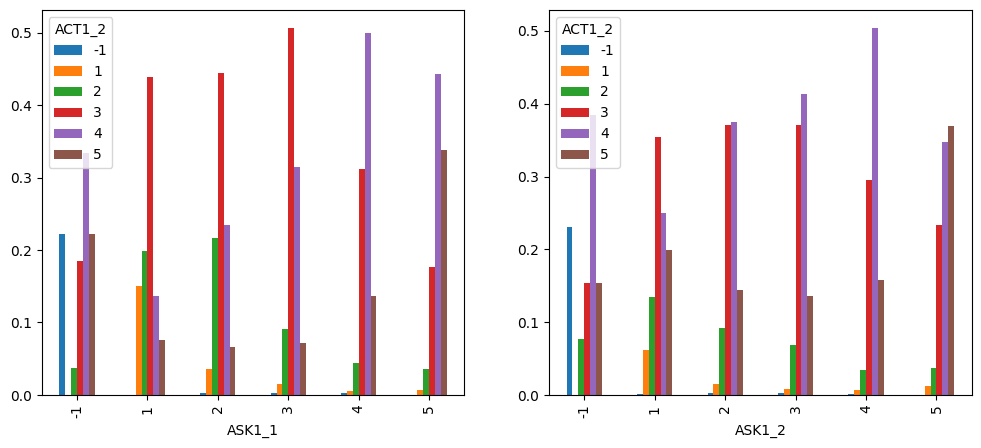

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

data.groupby('ASK1_1')['ACT1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[0])
data.groupby('ASK1_2')['ACT1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[1])

Both are good to use. Distributions are really similar in shape. Let's use one of them: ASK1_1

__FINGOALS: Do you have a current or recent financial goal?__

Probably, people with similar financial responsability will have similar answers to this question.

Some variables that can relate people with similar financial responsability are: agecat, ACT1_2, SAVEHABIT, PROPPLAN_3, PROPPLAN_4, GOALCONF


<AxesSubplot:xlabel='agecat'>

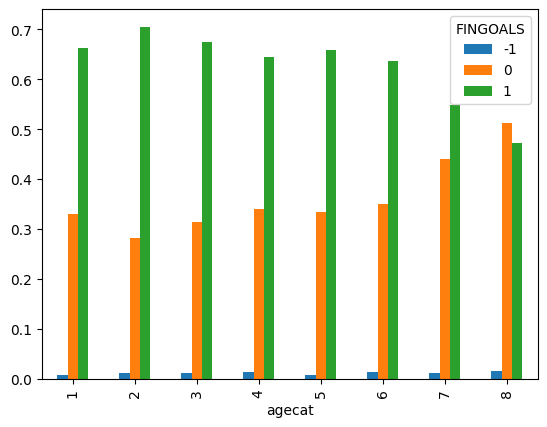

In [7]:
data.groupby('agecat')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

Answers do not vary that much among different ages

<AxesSubplot:xlabel='ACT1_2'>

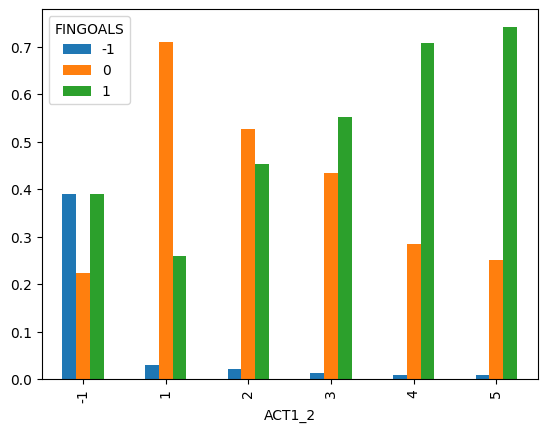

In [8]:
data.groupby('ACT1_2')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

Answers clearly vary with answers to ACT1_2, let's use it

<AxesSubplot:xlabel='SAVEHABIT'>

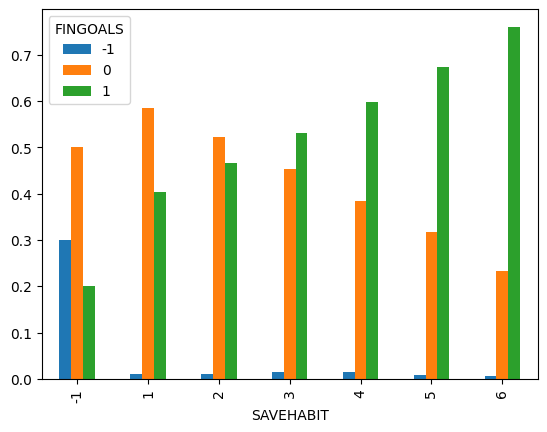

In [14]:
data.groupby('SAVEHABIT')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

Same. Use it

<AxesSubplot:xlabel='PROPPLAN_3'>

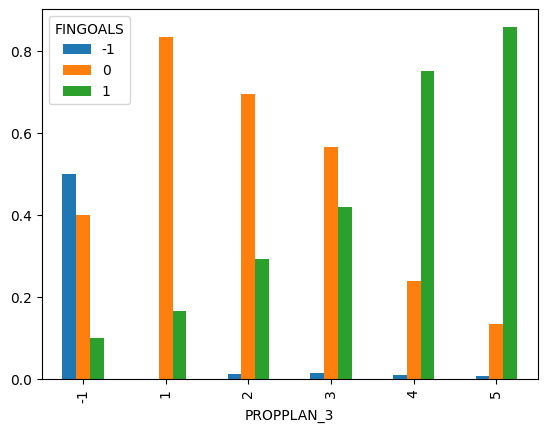

In [11]:
data.groupby('PROPPLAN_3')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

Same here. Let's use it

<AxesSubplot:xlabel='PROPPLAN_4'>

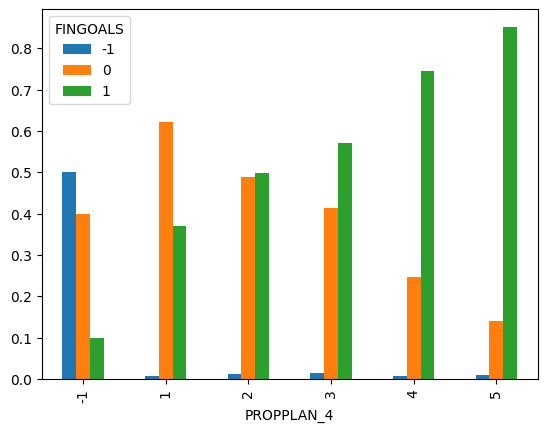

In [12]:
data.groupby('PROPPLAN_4')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

Again, but less discriminative. Let's use only PROPPLAN_3

<AxesSubplot:xlabel='GOALCONF'>

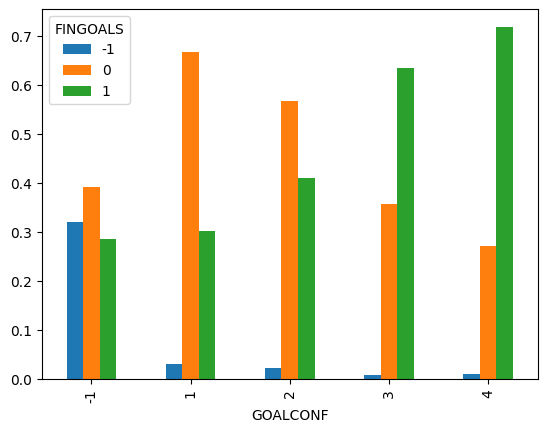

In [13]:
data.groupby('GOALCONF')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

Same happens here. Let's use it

Answers clearly vary with answers to SAVEHABIT, let's use it

In [ ]:
data.groupby('SAVEHABIT')['FINGOALS'].value_counts(normalize = True).unstack().plot.bar()

__8: I can't recall__

HSOC: Where respondent attended high school
- 1: US and territories
- 2: Outside the US
- 8: Can't recall

What do to?
- impute with mode

In [29]:
data['HSLOC'].value_counts()

 1    5386
-1     645
 2     342
 8      21
Name: HSLOC, dtype: int64

__98: Don't know__

HOUSERANGES: About how much do you pay for your home each month?

VALUERANGES: If you were to sell your home today, what do you think it would be worth?

MORTGAGE: What do you owe on your home today?

SAVINGSRANGES: How much money do you have in savings today?

514 rows

What to do?
- impute (how (?))

In [30]:
data[(data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] == 98).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7375,1,3,4,4,4,49,3,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
9688,1,3,4,5,4,58,3,3,2,3,...,1,1,2,0,0,0,0,3,0,1.266602
12162,1,3,6,6,6,39,1,3,3,2,...,1,3,5,0,0,0,0,2,0,0.790106
8305,2,3,6,6,7,76,5,5,1,5,...,1,2,3,0,0,0,0,2,0,0.242530
9182,1,3,6,-1,-1,50,3,3,3,4,...,1,4,9,0,0,0,0,2,0,0.647301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8513,3,3,7,7,7,54,5,5,3,5,...,1,4,9,0,0,0,0,2,-5,1.264364
8708,3,3,6,5,6,50,3,1,4,2,...,1,3,5,1,0,0,1,2,-5,1.027399
13329,3,3,7,7,7,52,2,3,2,3,...,1,4,9,0,0,0,1,2,-5,1.364540


__99: Prefer not to say__

HOUSERANGES

VALUERANGES

MORTGAGE

SAVINGSRANGES

EMPLOY:
1. Self-employed
2. Work full-time for an employer or the military
3. Work part-time for an employer or the military
4. Homemaker
5. Full-time student
6. Permanently sick, disabled or unable to work
7. Unemployed or temporarily laid off
8. Retired
99. Prefer not to say

1384 rows in total

- 624 from HOUSERANGES
- 159 from VALUERANGES
- 498 from MORTGAGE
- 988 from SAVINGSRANGES
- 116 from EMPLOY

What to do?
- impute HOUSERANGES, VALUERANGES, MORTGAGE and SAVINGSRANGES the same way as in the 'Don't know' imputation
- impute EMPLOY taking into account salary, age and/or something more like that


In [31]:
data[(data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] == 99).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1,3,6,6,6,49,3,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
11079,1,3,5,4,7,51,1,3,2,3,...,1,2,4,0,0,1,1,3,0,1.370522
7852,1,2,5,6,7,50,3,4,3,3,...,1,3,7,0,0,0,1,3,1,1.292576
11221,1,1,3,5,4,37,1,1,4,1,...,1,4,9,0,0,1,0,3,0,1.025192
12990,2,2,7,7,7,67,2,3,1,3,...,1,3,5,0,0,0,0,1,0,0.866999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9430,2,3,-1,6,-1,73,5,4,2,4,...,0,3,7,0,0,0,0,2,1,0.715445
13085,3,2,7,7,7,50,3,2,5,4,...,1,3,7,0,0,0,0,1,-5,2.518084
13144,3,2,6,7,7,58,3,4,3,4,...,1,3,5,0,0,0,0,1,-5,1.577823


In [32]:
data[data['HOUSERANGES'] == 99].shape[0]

624

In [33]:
data[data['VALUERANGES'] == 99].shape[0]

159

In [34]:
data[data['MORTGAGE'] == 99].shape[0]

498

In [35]:
data[data['SAVINGSRANGES'] == 99].shape[0]

988

In [ ]:
data[data['EMPLOY'] == 99].shape[0]

116

## Target and Weights variables exploration

Data types:

In [ ]:
data.dtypes.value_counts()

int64      214
float64      2
dtype: int64

### Weights

__Variable finalwt__: the weights included in the dataset are important for ensuring that the results obtained from the survey are representative of the United States population. These weights are used to account for variations in the probability of selection and to adjust for differential nonresponse across different socioeconomic groups.

In machine learning, when using weighted data, you can include the weights in the model training process to adjust for sampling bias. The exact method for including weights depends on the specific machine learning algorithm you are using.

For example, if you are using scikit-learn library in Python, you can use the 'sample_weight' parameter in the 'fit' method to specify the weights for each training example. Other machine learning libraries may have different methods for incorporating weights.

### Target

__Target variable__: fpl (Federal poverty level)

- <100% Federal Poverty Level
- 100-199% Federal Poverty Level
- 200%+ Federal Poverty Level

In [ ]:
data.fpl.value_counts(normalize = True)

3    0.762277
2    0.134345
1    0.103378
Name: fpl, dtype: float64

The dataset is quite imbalanced